In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import pandas as pd

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)



# Problem & Dataset

* Chemistry is not a mostly loved subject.
* There are various chemical compounds. The problem here is to pronounce a common name knowing its formula.  
* So, we try to learn transition: molecular_formula->common_name.
* If you want, you can replace source and target variables to predict something else (sequential)

In [2]:
molecules = pd.read_csv('molecules.tsv',sep='\t')

def get_xy(x, y):
    global molecules
    is_str = lambda s: type(s) is str
    molecules = molecules[x.apply(is_str)& y.apply(is_str)]
    x = x[x.apply(is_str)& y.apply(is_str)]
    y = y[x.apply(is_str)& y.apply(is_str)]
    return x.values, y.apply(lambda s: ["START"]+list(s)+["END"])

source_seqs,target_seqs = get_xy(molecules.molecular_formula, molecules.common_name) #Replace here

In [3]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

C_{7}H_{11}NO_{5} : Ethyl 3-ethoxy-2-nitroacrylate
C_{20}H_{20}FN_{3}O : N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazole-5-carboxamide
C_{17}H_{23}NOS : N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxamide
C_{21}H_{29}N_{5}O_{3} : 2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-5,8-dioxo-5,6,7,8-tetrahydro-4H-pyrazolo[1,5-a]pyrrolo[3,4-d]pyrimidin-4-yl}-N-cyclopropylacetamide
C_{13}H_{22}BrN_{3}O_{2} : 4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)amino]-2-propyl-3(2H)-pyridazinone


In [4]:
target_letters = list(set([token for ts in target_seqs for token in ts]))
target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}

In [5]:
source_letters = list(set([token for word in source_seqs for token in word]))
source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}

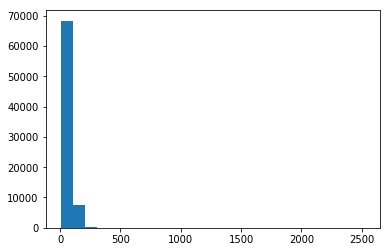

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,target_seqs)),bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150,max(list(map(len,target_seqs)))])

### Cast everything from symbols into matrix of int32. Pad with -1

In [7]:
def as_matrix(sequences,token_to_i, max_len=None,PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32') -1
    for i,seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


In [8]:
print(as_matrix(source_seqs[:10],source_letter_to_ix))

[[11 37 29 22 14  1 37 29 33 33 14 42  2 37 29 13 14 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [11 37 29 36 32 14  1 37 29 36 32 14 48 42 37 29  9 14  2 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [11 37 29 33 22 14  1 37 29 36  9 14 42  2  5 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [11 37 29 36 33 14  1 37 29 36 27 14 42 37 29 13 14  2 37 29  9 14 -1 -1
  -1 -1 -1 -1]
 [11 37 29 33  9 14  1 37 29 36 36 14 50 19 42 37 29  9 14  2 37 29 36 14
  -1 -1 -1 -1]
 [11 37 29 33  6 14  1 37 29 33 13 14 42 37 29  9 14  2 37 29  9 14 -1 -1
  -1 -1 -1 -1]
 [11 37 29 36 22 14  1 37 29 36  9 14 11 21 37 29 36 14 42  2 37 29 13 14
  -1 -1 -1 -1]
 [11 37 29 33 36 14  1 37 29 33 36 14 48 37 29  9 14 42 37 29  9 14  2 37
  29 36 14  5]
 [11 37 29 33 22 14  1 37 29 33 27 14 11 21 42 37 29 36 14  2 -1 -1 -1 -1
  -1 -1 -1 -1]
 [11 37 29 33 33 14  1 37 29 33 27 14 11 21 42 37 29 23 14 -1 -1 -1 -1 -1
  -1 -1 -1 -1]]


# Input variables

In [9]:
input_sequence = T.matrix('token sequence','int32')
target_target_letters = T.matrix('target target_letters','int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* Input sequence
* One-hot / embedding
* Encoder recurrent layer(s)
* Decoder recurrent layer(s)
* Softmax layer to predict probabilities

In [10]:
from lasagne.layers import *

##ENCODER
l_in = InputLayer(shape=(None, None), input_var=input_sequence)
l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence, -1)) 

l_emb = EmbeddingLayer(l_in, len(source_letters), 8)
l_rnn = GRULayer(l_emb, 100, only_return_final=True, mask_input=l_mask)

In [11]:
##DECODER
dec_in = InputLayer(shape=(None, None), input_var=target_target_letters)
dec_mask = InputLayer(shape=(None, None), input_var=T.neq(target_target_letters,-1))

dec_emb = EmbeddingLayer(dec_in, len(target_letters), 8)
dec_rnn = GRULayer(dec_emb, 100, hid_init=l_rnn, mask_input=dec_mask)# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1, dec_rnn.output_shape[-1]))

l_out = lasagne.layers.DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)

In [12]:
# Model weights
weights = get_all_params(l_out,trainable=True)
#print weights

In [13]:
network_output = get_output(l_out)
network_output = network_output.reshape([target_target_letters.shape[0],target_target_letters.shape[1],-1])
#If you use dropout do not forget to create deterministic version for evaluation

In [14]:
predictions_flat = network_output[:,:-1,:].reshape([-1,len(target_letters)])
targets = target_target_letters[:,1:].ravel()

#do not count loss for '-1' tokens
mask = T.nonzero(T.neq(targets,-1))

loss = lasagne.objectives.categorical_crossentropy(predictions_flat[mask], targets[mask]).mean()

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [15]:
#training
train = theano.function([input_sequence, target_target_letters], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_target_letters], loss, allow_input_downcast=True)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [16]:
#compile the function that computes probabilities for next token given previous text.

network_output = network_output.reshape((target_target_letters.shape[0],
                                         target_target_letters.shape[1], len(target_letters)))

last_word_probas = network_output[:,-1,:]

probs = theano.function([input_sequence, target_target_letters], last_word_probas, allow_input_downcast=True)

In [17]:
def generate_output(input,
                    output_prefix = ("START",),
                    END_token="END",
                    t=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    
    output = list(output_prefix)
    
    while True:
        next_y_probs = probs(as_matrix([input], source_letter_to_ix),
                             as_matrix([output], target_letter_to_ix)).ravel()
        next_y_probs = next_y_probs ** t / np.sum(next_y_probs ** t)

        if sample:
            ix = np.random.choice(np.arange(len(target_letters)), p=next_y_probs)
            next_y = target_letters[ix]
        else:
            next_y = target_letters[next_y_probs.argmax()]
        
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y==END_token:
            break
            
    return output

# Model training

In [18]:
source_seqs = np.array(source_seqs)
target_seqs = np.array(target_seqs)

In [19]:
def sample_batch(source_seqs,target_seqs, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0,len(source_seqs),size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix],source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix],target_letter_to_ix)
    
    return source_seqs_batch,target_seqs_batch

In [20]:
from IPython.display import clear_output

In [ ]:
from tqdm import tqdm

#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):


    avg_cost = 0;
    
    for _ in tqdm(range(batches_per_epoch)):
        
        x,y = sample_batch(source_seqs,target_seqs,batch_size)
        avg_cost += train(x, y).mean()
    if epoch % 5 == 0:
        clear_output(True)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(source_seqs))
        print (source_seqs[ind],':', ''.join(generate_output(source_seqs[ind],sample=True)[1:-1]))

Epoch 95 average loss = 0.5788296856284142
C_{24}H_{22}F_{5}N_{3}O_{4} : 2-{[4-(4-Methoxyphenyl)-3-thienyl]sulfanyl}methylene]-2-(2-chlorophenyl)-4H-chromene-3-carboxylic acid
C_{13}H_{20}ClN_{3}O_{2} : N-(3-Chlorophenyl)-3-[1-[(E)-(methylamino)methyl]-2-pyrrolidinone
C_{14}H_{20}N_{2}O : 1-[3-Fluoro-1-(2-fluorophenyl)aniline]-4-naphthaleneseridione
C_{12}H_{12}Cl_{3}NO : 1-Cyclopropyl-1-oxo-2-(2-propoxyethoxy)propanoyl}benzonate>l)]sulfonamide


  0%|          | 2/500 [00:00<00:41, 12.08it/s]

C_{15}H_{12}Cl_{2}FNS : 7-[({4-[(3-Chlorobenzyl)oxy]-N-(phenoxymethyl)cyclopropanecarboxamide


100%|██████████| 500/500 [00:51<00:00,  9.67it/s]


Epoch 96 average loss = 0.5743788164258004
C_{21}H_{26}N_{2}O_{2} : 4-Amino-1-(1H-1,2-benzodioxino-1,4-dihydropyrido[2,3-a]isoquinolin-2-yl)-1-[4-iodo-3-hydramido-4(5H)-pyridazinone
C_{8}H_{12}ClN : 2-(Ethylsulfamoyl)phenium
C_{19}H_{13}N_{3}O : 4-[(3,5-Dimethylphenyl)sulfamoate
C_{20}H_{21}ClN_{2}O_{3}S : [(2-{[(2-Bromophenyl)sulfonyl]-1-methoxy-6,7-diphenyl-2-thiomorpholinecarboxamide hydrac diamide


  0%|          | 1/500 [00:00<01:29,  5.55it/s]

C_{16}H_{24}N_{4}O : N-(1,1-Diethylmethyl)-N-(3,4-dichlorophenyl)-5-piperidinecarboxamide


100%|██████████| 500/500 [00:53<00:00,  9.35it/s]


Epoch 97 average loss = 0.5765019021034241
C_{12}H_{16}FN_{5} : 5-(3,3-Dihydro-1H-1,2,4-triazol-3-yl)-5-methoxybenzenesulfonamide
C_{16}H_{25}NOS_{2} : N-[3-(2-Methyl-2-propanyl)-4,6'-bis(6-methyl-2,4-dimethyl-1H-pyrrol-1-yl)benzoic acid
C_{15}H_{30}N_{2}O_{3} : N,N-Dimethyl-4-[4-(tetrahydro-2-furanylmethyl)-2-methoxybenzyl]imino}benzoate
C_{16}H_{26}N_{4}O_{3}S : N-[2-(1,3,5,5,6,8,6,7a-D,8-tetrahydro-2H-1,4-benzodioxin-6-yl)ethyl]-9-phenylbenzene


  0%|          | 1/500 [00:00<00:57,  8.74it/s]

C_{26}H_{25}F_{2}N_{3}O_{3}S : 2-(3-Cyanobenzoyl)-6-{[3-(2-thienylmethyl)-3-morpholinyl]amino}-2,6-dichlorobenzoic acid


100%|██████████| 500/500 [00:52<00:00,  9.61it/s]


Epoch 98 average loss = 0.5724894424676895
C_{18}H_{25}N_{3}O_{5} : N-[1-(2,4-Dimethylphenyl)-3-(3-methoxyphenyl)-2,3-dihydro-2-propanone
C_{11}H_{17}NO_{4}S_{2} : 5-[Isobutyloxy)methylene]-2-thiophene-7-carboxylate
C_{10}H_{14}N_{4}O : N-[3-(2-Methyl-2-propen-1-yl)propyl]-2-furamide
C_{23}H_{26}ClNO_{6} : 2-(Cyclopentyl-3-{[(3-cyanophenyl)sulfonyl]-4carbaminocyclohexanecarbonitrile


  0%|          | 2/500 [00:00<00:43, 11.51it/s]

C_{20}H_{21}N_{5}O_{2} : (2,2-Dimethyl-beta-alanyl-1H-pyrazol-4-yl)(soc-ethyl)carbamoyl]-4-(methylsul)-1-benzofuran-1-yl diencyl-3,3,5-trimethylbicyclo[2.3.1]nona--1,1-d]quinoxalin-2-amine


100%|██████████| 500/500 [00:54<00:00,  9.56it/s]


Epoch 99 average loss = 0.5787802811264992
C_{11}H_{21}NO_{3} : 2-Amino-N-(2,3,4-trifluoro-4H-1,3,4-triazol-3-oncy)methyl}benzene
C_{19}H_{19}N_{3}O_{2}S : 2-{[2-(Aminomethyl)-3-nitrobenzoyl]amino}benzoic acid
C_{10}H_{13}N_{3}O : [(4-Phenoxyphenyl)amino]methyl}benzamide
C_{10}H_{17}N_{5}O : N-(1-Methoxycyclohexyl)-1-(2-methyl-2-pentanyl)-1H-1,2,4-triazol-5-amine
C_{19}H_{18}N_{6}OS : 2-(4-Amanophenoxy)-3-(3,4-dimethylphenyl)-3-oxo-4-propyl-5,7-pyrimidinedicarboxamide


In [25]:
print (source_seqs[ind],':', ''.join(generate_output(" C_{4}H_{1}", t=2)[1:-1]))

C_{19}H_{18}N_{6}OS : (1R,3R)-1-(2-Amino-1-phenyl-6,6-dihydro-5H-1,4-benzoxazin-4-yl)-2-oxoethyl (1R,3R)-1-(1-phenylethyl)-1,3-benzoxazole-3-carboxamide


## Homework part 2 - chemistry (6 pt total)

* [4pts] Complete notebook and make sure target sequence is being generated.
* [2pts] Modify train cycle to output sequences with different sampling strategies (varying t in range $[0, + \infty)$ and try to find out which sampling strategy is the best for current task)


## [bonus] [2pts]  Latex display
Swap target and source and learn name->formula, then try to reach quality when almos any generated sequence is a valid Latex formula and implement its prinitng using IPython magic in jupyter. It would be good if you create a demo and pass there some chemical (or not?) names

In [26]:
import IPython
z = IPython.display.Latex(data='$2+2$')
IPython.display.display(z)

<IPython.core.display.Latex object>

# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind